In [2]:
from ms_autoencoder import GraphEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.cluster import normalized_mutual_info_score
from torch import nn, optim
import torch
import numpy as np
from tqdm import tqdm
from matplotlib.cm import get_cmap
from matplotlib import pyplot as plt
import networkx as nx
import os 
import pickle
import seaborn as sns

#Make reproducible results
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

#For plotting
name = "Accent_r"
cmap = get_cmap(name) 
colors = cmap.colors  

sns.set_theme()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
data_dir = '/Users/ryznerf/Documents/0_MIT/Spring_2022/0_Projects/3_Networks_project/community-detetction-deep-learning/Data'
file_path = os.path.join(data_dir, 'toy_dataset.pkl')
with open(file_path, 'rb') as f:
    g = pickle.load(f)
    
#initialize single position for all visualizations    
pos = nx.spring_layout(g, seed=SEED)

### Preprocessing the graph to put it into the Autoencoder

In [4]:
#Preprocessing
X = np.asarray(nx.to_numpy_matrix(g))
partition_true = g.graph['partition']
partition_true = {node:i for i, cluster in enumerate(partition_true) for node in cluster} 
Y = np.array(list(partition_true.values()))
k = len(np.unique(Y))

#Wine dataset: Original Implementation
'''
from sklearn.datasets import load_wine
from sklearn import preprocessing

data = load_wine()
X = data.data
Y = data.target
k = len(np.unique(Y))

min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
'''

S = cosine_similarity(X, X)


#Should this be X.sum or S.sum ? From Github Implementation
D = np.diag(1.0 / np.sqrt(S.sum(axis=1)))
X_train = torch.tensor(D.dot(S).dot(D)).float().to(device)

#My Reading of the Paper
'''
D = np.diag(X.sum(axis=1))
X_train = np.linalg.inv(D) @ S
X_train = torch.tensor(X_train).float().to(device)
'''



'\nD = np.diag(X.sum(axis=1))\nX_train = np.linalg.inv(D) @ S\nX_train = torch.tensor(X_train).float().to(device)\n'

### Training the Autoencoder

In [ ]:
epochs = 500
beta = 0   #Unregularized works best. Maybe the KL divergence implementation is flawed
rho = 0.5 #paper had 0.01
lr = 1e-4

#First cycle
layers = [len(X_train)] + [512, 256, 512] + [len(X_train)]
model = GraphEncoder(layers, k).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

#Train first cycle
with tqdm(total=epochs) as tq:
  for epoch in range(1, epochs + 1):
    optimizer.zero_grad()
    X_hat = model(X_train)
    loss = model.loss(X_hat, X_train, beta, rho)
    nmi = normalized_mutual_info_score(model.get_cluster(random_state=SEED), Y, average_method='arithmetic')
    loss.backward()
    optimizer.step()
    tq.set_postfix(loss='{:.3f}'.format(loss), nmi='{:.3f}'.format(nmi))
    tq.update()

embedding = model.outputs['lin2']

  0%|          | 0/500 [00:00<?, ?it/s]

### Performance Evaluation

In [7]:
partition_true = g.graph['partition']
partition_true = {node:i for i, cluster in enumerate(partition_true) for node in cluster} 
partition_predicted = model.get_cluster(random_state=SEED)
partition_predicted = {node: comm for node, comm in zip(list(partition_true.keys()), partition_predicted)}

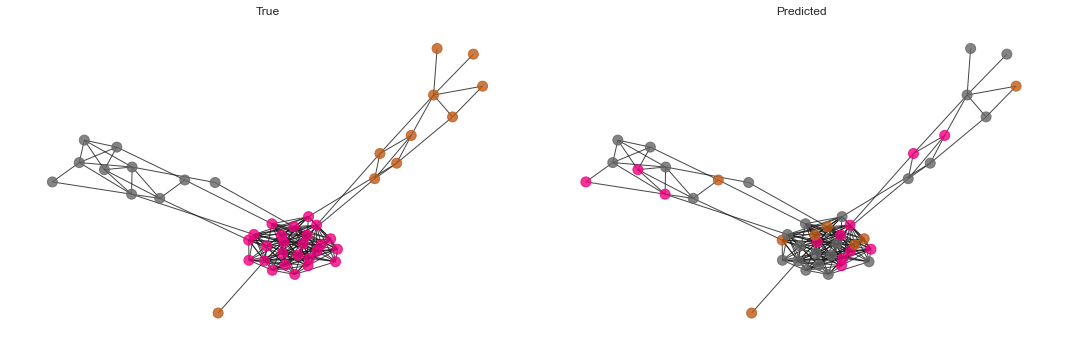

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
nx.draw(g,
        pos,
        node_size=100,
        alpha=0.8,
        node_color=[colors[community] for node, community in partition_true.items()],
        with_labels=False,
        ax=axes[0]
       )
axes[0].set_title('True')

nx.draw(g,
        pos,
        node_size=100,
        alpha=0.8,
        node_color=[colors[community] for node, community in partition_predicted.items()],
        with_labels=False,
        ax=axes[1]
       )
axes[1].set_title('Predicted')
plt.tight_layout()
plt.show()


In [17]:
from sklearn.metrics import normalized_mutual_info_score


normalized_mutual_info_score(list(partition_true.values()), 
                             list(partition_predicted.values()))

0.1567553399279871